# NLP

## Import necessary libraries

In [28]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

import tensorflow as tf
import tensorflow.keras
import re
import keras
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, GlobalAveragePooling1D, concatenate
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint 

## Import Dataset

In [29]:
# Reading the csv files
fashion_df = pd.read_csv("./datasets/fashion_text_dataset.csv")

In [30]:
# Showing the first few columns of the dataset
fashion_df.head(10)

,description,category
0,Sless Flippy Mini Dress,women dresses
1,Midi Pleated Skirt,women skirts
2,Stamos Mix Silk Raglan Knit Sweater,men outwear
3,Basic Training Tank Top,men tops
4,Fashion Camouflage Hooded Jacket,women outwear
5,Straight Leg Sweatpants,men trousers
6,Hooded Pull Over,men outwear
7,Ally 3/4 Spring Pullover,women outwear
8,Cropped Pleated Pants,women trousers
9,NB Athletics Archive Run Pants,men trousers


In [31]:
fashion_df.count()

description    2000
category       2000
dtype: int64

# Information of the dataset

## Create a bag of words

In [32]:
docs = map(''.join, fashion_df[['description']].values.tolist())

cv = CountVectorizer(stop_words="english", 
                        analyzer='word', 
                        ngram_range=(1, 1), 
                        max_df=1.0, min_df=1, 
                        max_features=None)


# Generates word count for the words in the docs
word_count_vector = cv.fit_transform(docs)
print(word_count_vector.shape)

(2000, 1538)


## Get more insights from IDF & TFIDF

In [33]:
# ---  IDF  ---
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
 
# idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf"])
 
# sort ascending
df_idf = df_idf.sort_values(by=['idf'])
df_idf.head(10)

,idf
shorts,3.060139
skirt,3.240110
dress,3.273526
shirt,3.313135
sleeve,3.624669
pants,3.681421
jacket,3.757215
midi,3.957011
fit,3.966673
short,4.016435


In [34]:
# ---  TFIDF  ---
# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(word_count_vector)

feature_names = cv.get_feature_names()
 
#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]
 
#print the scores
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df = df.sort_values(by=["tfidf"],ascending=False)
df.head(10)

,tfidf
sless,0.640754
flippy,0.607902
mini,0.386706
dress,0.265232
0002,0.000000
prem,0.000000
prairie,0.000000
power,0.000000
postgame,0.000000
popover,0.000000


## TFIDF Embedding

In [35]:
# settings that you use for count vectorizer will go here
tfidf_vectorizer=TfidfVectorizer(use_idf=True, 
                                 stop_words="english", 
                                 analyzer='word', 
                                 ngram_range=(1, 1))

docs = map(''.join, fashion_df[['description']].values.tolist())

# just send in all your docs here
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)

print('Length of vocab: ', len(tfidf_vectorizer.get_feature_names()))
print('Sample of vocab', tfidf_vectorizer.get_feature_names()[:]) # Sample of features

Length of vocab:  1538
Sample of vocab ['0002', '0004', '0005', '0006', '0007', '0011', '0012', '0016', '0096', '0175', '0241', '026', '035', '056', '10k', '119', '129', '18882', '18883', '18884', '19', '1979', '237', '28', '2c', '2pcs', '2x', '30', '3031', '3060', '360', '36272', '37', '3d', '3s', '430', '4g', '50', '505', '511', '52797', '54', '59406', '59407', '59463', '596346', '5palle', '60', '66', '705', '712', '720', '721', '724', '779', '78', '790', '79488', '79697', '90', '90s', '93308w', '93343', '93368w', '93417w', 'a003', 'a249', 'ab', 'abrig', 'abstract', 'ac', 'accent', 'accordian', 'acid', 'action', 'activchill', 'active', 'ad', 'adda', 'ader', 'adidas', 'adjustable', 'adrian', 'aery', 'aiden', 'air', 'aja', 'alchemy', 'alex', 'alice', 'ally', 'aloha', 'altitude', 'alvia', 'amari', 'amelie', 'american', 'amnig', 'ams', 'animal', 'ankle', 'ann', 'anorak', 'anthoney', 'antonia', 'aop', 'août', 'applique', 'ar', 'arch', 'archive', 'arctic', 'arden', 'armour', 'army', 'asia'

# Data Processing and Split data

## Split data to Train and Validation Set

In [36]:
# 80% Training 20% Validation
_X_train, _X_test, y_train, y_test = train_test_split(fashion_df['description'], fashion_df['category'], test_size=0.2)

## Include TFIDF to our model

In [37]:
vect = TfidfVectorizer(ngram_range=(1, 2), 
                       stop_words='english', 
                       analyzer='word')
vect.fit(_X_train)

# _X_train and _X_test  --- vectorized ---> X_train and X_test
X_train = vect.transform(_X_train)
X_test = vect.transform(_X_test)

print(X_train.shape)
print(X_test.shape)

(1600, 4725)
(400, 4725)


# Training using Deep Neural Network

In [38]:
MAX_FEATURES = 2000
MAX_LENGTH = 20
EMBED_SIZE = 20
BATCH_SIZE = 32
EPOCHS = 5

## Build the model

In [39]:
X_train.shape[1]

4725

In [40]:
model = Sequential([
    Dense(256,input_shape=(X_train.shape[1],),activation='relu'),
    Dropout(0.5),
    Dense(128,activation='relu'),
    Dropout(0.2),
    Dense(10,activation='softmax')
])

model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['acc'])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               1209856   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 1,244,042
Trainable params: 1,244,042
Non-trainable params: 0
_________________________________________________________________


In [42]:
le = preprocessing.LabelEncoder()
y_train_ = le.fit_transform(y_train)
y_train__ = tf.keras.utils.to_categorical(y_train_)
y_train__  # DEBUG

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [43]:
models = model.fit(X_train, y_train__,
                    batch_size=256,
                    epochs=25,
                    verbose=1,
                    validation_split=0.15)

Train on 1360 samples, validate on 240 samples
Epoch 1/25
1360/1360 [==============================] - 0s 283us/step - loss: 2.2998 - acc: 0.1235 - val_loss: 2.2909 - val_acc: 0.2167
Epoch 2/25
1360/1360 [==============================] - 0s 209us/step - loss: 2.2752 - acc: 0.2787 - val_loss: 2.2735 - val_acc: 0.3292
Epoch 3/25
1360/1360 [==============================] - 0s 190us/step - loss: 2.2401 - acc: 0.4228 - val_loss: 2.2416 - val_acc: 0.3833
Epoch 4/25
1360/1360 [==============================] - 0s 186us/step - loss: 2.1769 - acc: 0.5375 - val_loss: 2.1857 - val_acc: 0.4083
Epoch 5/25
1360/1360 [==============================] - 0s 193us/step - loss: 2.0741 - acc: 0.6037 - val_loss: 2.0977 - val_acc: 0.4792
Epoch 6/25
1360/1360 [==============================] - 0s 182us/step - loss: 1.9202 - acc: 0.7103 - val_loss: 1.9720 - val_acc: 0.5583
Epoch 7/25
1360/1360 [==============================] - 0s 177us/step - loss: 1.7052 - acc: 0.7926 - val_loss: 1.8056 - val_acc: 0.6208
E

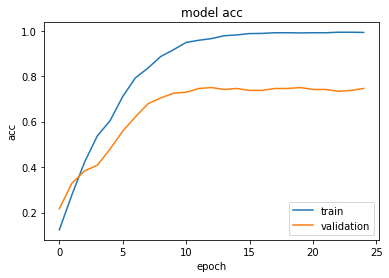

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

plot_train(models)

Evaluation

In [45]:
vect = TfidfVectorizer(ngram_range=(1, 1), stop_words='english', analyzer='word')
vect.fit(_X_train)

x_train_vectorized = vect.transform(_X_train)
x_test_vectorized = vect.transform(_X_test)

print(x_train_vectorized.shape)
print(x_test_vectorized.shape)

(1600, 1340)
(400, 1340)
